# Project 7 / Airport Delays + Cluster Analysis

## Description

The FAA wants to cut down on delays nationwide, and the most important part of this task is understanding the characteristics and groupings of airports based on a dataset of departure and operational delays.

- A certain degree of delay is expected in airport operations, however the FAA is noticing significant delays with certain airports
- When a flight takes off, it's departure delay is recorded in minutes, as well as operational data relating to this delay
- At the end of the year, this data is averaged out for each airport. Your datasets have these averaged for a 10 year range between 2004 and 2014
- Over this 10 year range, some delay times have not improved or have worsened.

**Point:** Your task is to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.

### Project Summary

In this project, we're going to be using three different datasets related to airport operations. These include a dataset detailing the arrival and departure delays/diversions by airport, a dataset that provides metrics related to arrivals and departures for each airport, and a dataset that details names and characteristics for each airport code.

You will help the FAA:

- Organize and store their data so that they can easily understand it after your consulting work is done
- Mine and refine the data to uncover its basic attributes and characteristics
- Use your skills with PCA to uncover the core components of operations related to delays.
- Transfer your database to AWS so that FAA staff around the country can access your data and findings

When you've finished your analysis, the FAA would like a report detailing your findings, with recommendations as to which airports and operational characteristics they should target to decrease delays.

Here are some questions to keep in mind:
- What operational factors are most directly correlated to delays?
- Take a look at airports groupings - are there any relationships by region? Size?


## Requirements

- Complete all of the tasks below:
- Write a problem statement & describe the goals of your study to be included in the final report
- Create a database to store your data; the FAA has dictated that you use PostgreSQL
- Conduct Exploratory Data Analysis to understand the attributes of our data; include your EDA findings in your final report to the FAA
- Mine & refine your data
- Conduct a PCA to discover the principal components behind departure delays
- Present the results of your findings in a formal report to the FAA, including the problem statement, summary statistics of the takeoff delays and operational delays, your PCA analysis detailing the principal components related to relays, and a case study on one specific airport that best illustrates your findings to FAA officials.
- Plot your PCA analysis on a 3-dimensional graph
- Copy your dataset and findings to your own AWS database for convenient FAA access.

#### Pre-work 1: Load the python libraries that you will need for this project 

In [2]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

plt.style.use('fivethirtyeight')

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

#pd.set_option('display.notebook_repr_html', False)

/Users/jam3/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Pre-work 2: Examine your data 

In [3]:
clx_df = pd.read_csv("./supporting/airport_cancellations.csv")
clx_df = clx_df.dropna() 
clx_df.columns = [col.replace(' ', '_').lower() for col in clx_df.columns ]

clx_df.head(2)

airport    year  departure_cancellations  arrival_cancellations  \
0     ABQ  2004.0                    242.0                  235.0   
1     ABQ  2005.0                    221.0                  190.0   

   departure_diversions  arrival_diversions  
0                  71.0                46.0  
1                  61.0                33.0

In [4]:
ops_df = pd.read_csv("./supporting/airport_operations.csv")
ops_df.columns = [col.replace(' ', '_').replace('-', '_').lower() for col in ops_df.columns ]
ops_df = ops_df.dropna() 
ops_df[:2]

airport  year  departures_for_metric_computation  \
0     ABQ  2004                              53971   
1     ABQ  2005                              51829   

   arrivals_for_metric_computation  percent_on_time_gate_departures  \
0                            53818                            0.803   
1                            51877                            0.814   

   percent_on_time_airport_departures  percent_on_time_gate_arrivals  \
0                              0.7809                         0.7921   
1                              0.7922                         0.8001   

   average_gate_departure_delay  average_taxi_out_time  \
0                         10.38                   9.89   
1                          9.60                   9.79   

   average_taxi_out_delay  average_airport_departure_delay  \
0                    2.43                             12.1   
1                    2.29                             11.2   

   average_airborne_delay  average_taxi_in_delay  average_block_delay  \
0                    2.46                   0.83                 2.55   
1                    2.26                   0.89                 2.34   

   average_gate_arrival_delay  
0                       10.87  
1                       10.24

In [5]:
arpt_df = pd.read_csv("./supporting/airports.csv")
arpt_df = arpt_df.dropna() 
arpt_df.columns = [col.replace(' ', '_').lower() for col in arpt_df.columns]
arpt_df.head(2)

key locid          ap_name                          alias facility_type  \
0  3443.0   STX  HENRY E ROHLSEN  Henry E Rohlsen Int'l Airport       Airport   
2  2886.0   PSE        MERCEDITA           Aeropuerto Mercedita       Airport   

  faa_region            county           city state     ap_type   latitude  \
0        ASO  -VIRGIN ISLANDS-  CHRISTIANSTED    VI  Public Use  17.701556   
2        ASO            #NAME?          PONCE    PR  Public Use  18.008306   

   longitude boundary_data_available  
0 -64.801722                     Yes  
2 -66.563028                     Yes

In [6]:
def conv_to_urf(a):
    return str(a).decode('utf-8')

arpt_df.alias = arpt_df.alias.apply(conv_to_urf)

### Intro: Write a problem statement / aim for this project

We want to understand the behavior of flight cancellations

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [6]:
%reload_ext sql
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

In [7]:
engine = create_engine('postgresql://localhost:5432')

# sqlalchemy
conn = engine.connect()
conn.execute("commit")
conn.execute("create database project7")
conn.close()

#### Load our csv files into tables

In [8]:
engine = create_engine('postgresql://localhost:5432/project7')
conn = engine.connect()

#pd.read_csv("./supporting/airports.csv", encoding='utf-8').\
#            to_sql('operations',con=conn,if_exists='replace',index=False)

clx_df.to_sql('clx', con=conn, if_exists='replace',index=False)
ops_df.to_sql('ops', con=conn, if_exists='replace',index=False) 
arpt_df.to_sql('arpt', con=conn, if_exists='replace',index=False)

#### Join airport_cancellations.csv and airport_operations.csv into one table

Query the database for our intial data

In [11]:
# %%sql postgresql://localhost:5432/project7
# SELECT *
# FROM clx, ops
# WHERE clx.airport=ops.airport and clx.year=ops.year

799 rows affected.


[(u'ABQ', 2004.0, 242.0, 235.0, 71.0, 46.0, u'ABQ', 2004L, 53971L, 53818L, 0.803, 0.7809, 0.7921, 10.38, 9.89, 2.43, 12.1, 2.46, 0.83, 2.55, 10.87),
 (u'ABQ', 2005.0, 221.0, 190.0, 61.0, 33.0, u'ABQ', 2005L, 51829L, 51877L, 0.814, 0.7922, 0.8001, 9.6, 9.79, 2.29, 11.2, 2.26, 0.89, 2.34, 10.24),
 (u'ABQ', 2006.0, 392.0, 329.0, 71.0, 124.0, u'ABQ', 2006L, 49682L, 51199L, 0.7983, 0.7756, 0.7746, 10.84, 9.89, 2.16, 12.33, 2.12, 0.84, 2.66, 11.82),
 (u'ABQ', 2007.0, 366.0, 304.0, 107.0, 45.0, u'ABQ', 2007L, 53255L, 53611L, 0.8005, 0.7704, 0.7647, 11.29, 10.34, 2.4, 12.95, 2.19, 1.29, 3.06, 12.71),
 (u'ABQ', 2008.0, 333.0, 300.0, 79.0, 42.0, u'ABQ', 2008L, 49589L, 49512L, 0.8103, 0.7844, 0.7875, 10.79, 10.41, 2.41, 12.32, 1.82, 1.03, 2.79, 11.48),
 (u'ABQ', 2009.0, 192.0, 162.0, 74.0, 26.0, u'ABQ', 2009L, 42550L, 42704L, 0.8341, 0.8147, 0.8224, 9.24, 9.88, 1.89, 10.45, 1.74, 0.92, 1.98, 9.27),
 (u'ABQ', 2010.0, 222.0, 177.0, 71.0, 50.0, u'ABQ', 2010L, 42302L, 42169L, 0.8144, 0.7907, 0.8047, 10.25, 9.95, 2.05, 11.58, 1.66, 0.95, 1.9, 10.23),
 (u'ABQ', 2011.0, 345.0, 294.0, 77.0, 61.0, u'ABQ', 2011L, 42283L, 42297L, 0.8072, 0.7758, 0.8022, 10.81, 10.5, 2.51, 12.57, 1.58, 0.84, 1.87, 10.63),
 (u'ABQ', 2012.0, 237.0, 181.0, 65.0, 60.0, u'ABQ', 2012L, 39105L, 39107L, 0.8219, 0.794, 0.8177, 10.55, 10.27, 2.32, 12.11, 1.41, 0.98, 1.8, 9.73),
 (u'ABQ', 2013.0, 232.0, 212.0, 62.0, 46.0, u'ABQ', 2013L, 35277L, 34989L, 0.771, 0.7402, 0.7554, 12.56, 10.77, 2.64, 14.28, 1.6, 0.92, 2.35, 12.76),
 (u'ABQ', 2014.0, 315.0, 274.0, 66.0, 37.0, u'ABQ', 2014L, 33292L, 33137L, 0.7451, 0.7148, 0.732, 14.3, 10.64, 2.41, 15.99, 1.73, 1.02, 2.4, 14.72),
 (u'ANC', 2004.0, 473.0, 532.0, 73.0, 30.0, u'ANC', 2004L, 16503L, 15511L, 0.7109, 0.677, 0.6502, 21.45, 12.41, 2.92, 23.05, 4.03, 1.08, 5.93, 22.62),
 (u'ANC', 2005.0, 424.0, 484.0, 74.0, 31.0, u'ANC', 2005L, 72043L, 67034L, 0.7394, 0.7061, 0.6955, 18.36, 12.19, 2.78, 19.97, 3.65, 1.01, 4.96, 19.35),
 (u'ANC', 2006.0, 367.0, 436.0, 88.0, 50.0, u'ANC', 2006L, 75708L, 69995L, 0.7771, 0.7455, 0.711, 15.56, 12.84, 2.54, 17.07, 4.29, 0.72, 5.83, 17.71),
 (u'ANC', 2007.0, 359.0, 423.0, 93.0, 54.0, u'ANC', 2007L, 78741L, 73323L, 0.7838, 0.7457, 0.7196, 15.69, 13.19, 2.29, 17.52, 5.13, 0.39, 5.87, 18.09),
 (u'ANC', 2008.0, 268.0, 355.0, 97.0, 57.0, u'ANC', 2008L, 76606L, 72479L, 0.7972, 0.7698, 0.7573, 13.45, 13.44, 1.86, 14.72, 5.13, 0.63, 5.93, 15.89),
 (u'ANC', 2009.0, 354.0, 421.0, 84.0, 80.0, u'ANC', 2009L, 67252L, 63135L, 0.8112, 0.7952, 0.8264, 15.1, 12.49, 1.55, 15.88, 3.85, 0.31, 4.19, 15.95),
 (u'ANC', 2010.0, 149.0, 204.0, 84.0, 32.0, u'ANC', 2010L, 73089L, 68125L, 0.7992, 0.776, 0.8045, 17.77, 11.97, 1.79, 18.83, 3.75, 0.37, 3.91, 20.28),
 (u'ANC', 2011.0, 191.0, 265.0, 87.0, 36.0, u'ANC', 2011L, 72556L, 66845L, 0.8276, 0.805, 0.8292, 14.56, 11.89, 1.66, 15.6, 3.92, 0.55, 4.01, 13.93),
 (u'ANC', 2012.0, 216.0, 284.0, 78.0, 36.0, u'ANC', 2012L, 70322L, 66453L, 0.8442, 0.8235, 0.8521, 10.01, 11.71, 1.52, 11.0, 3.86, 0.34, 3.75, 9.33),
 (u'ANC', 2013.0, 141.0, 184.0, 65.0, 40.0, u'ANC', 2013L, 69984L, 65469L, 0.8432, 0.8228, 0.8631, 9.18, 12.03, 1.51, 10.09, 3.4, 0.47, 3.82, 8.46),
 (u'ANC', 2014.0, 111.0, 162.0, 74.0, 28.0, u'ANC', 2014L, 71099L, 66704L, 0.8288, 0.8074, 0.86, 11.33, 11.33, 1.33, 12.34, 4.09, 0.54, 4.57, 10.82),
 (u'ATL', 2004.0, 7870.0, 8433.0, 737.0, 772.0, u'ATL', 2004L, 477323L, 473249L, 0.7596, 0.5757, 0.737, 13.59, 20.45, 8.73, 21.36, 5.0, 2.79, 4.69, 15.31),
 (u'ATL', 2005.0, 13837.0, 14480.0, 790.0, 1080.0, u'ATL', 2005L, 484570L, 480171L, 0.7413, 0.6216, 0.7337, 15.5, 18.52, 7.26, 21.8, 4.24, 2.72, 4.62, 17.23),
 (u'ATL', 2006.0, 6624.0, 7301.0, 913.0, 787.0, u'ATL', 2006L, 483334L, 478735L, 0.715, 0.5324, 0.7205, 16.2, 20.38, 9.63, 24.85, 3.71, 4.13, 4.72, 16.95),
 (u'ATL', 2007.0, 6796.0, 7790.0, 920.0, 1045.0, u'ATL', 2007L, 491826L, 486799L, 0.7167, 0.5713, 0.7446, 16.77, 19.67, 8.28, 24.18, 3.88, 4.17, 4.43, 16.09),
 (u'ATL', 2008.0, 5830.0, 6705.0, 982.0, 1072.0, u'ATL', 2008

In [13]:
full_ops_df = _.DataFrame()

In [14]:
full_ops_df.head()

airport    year  departure_cancellations  arrival_cancellations  \
0     ABQ  2004.0                    242.0                  235.0   
1     ABQ  2005.0                    221.0                  190.0   
2     ABQ  2006.0                    392.0                  329.0   
3     ABQ  2007.0                    366.0                  304.0   
4     ABQ  2008.0                    333.0                  300.0   

   departure_diversions  arrival_diversions airport  year  \
0                  71.0                46.0     ABQ  2004   
1                  61.0                33.0     ABQ  2005   
2                  71.0               124.0     ABQ  2006   
3                 107.0                45.0     ABQ  2007   
4                  79.0                42.0     ABQ  2008   

   departures_for_metric_computation  arrivals_for_metric_computation  \
0                              53971                            53818   
1                              51829                            51877   
2                              49682                            51199   
3                              53255                            53611   
4                              49589                            49512   

              ...              percent_on_time_airport_departures  \
0             ...                                          0.7809   
1             ...                                          0.7922   
2             ...                                          0.7756   
3             ...                                          0.7704   
4             ...                                          0.7844   

   percent_on_time_gate_arrivals  average_gate_departure_delay  \
0                         0.7921                         10.38   
1                         0.8001                          9.60   
2                         0.7746                         10.84   
3                         0.7647                         11.29   
4                         0.7875                         10.79   

   average_taxi_out_time  average_taxi_out_delay  \
0                   9.89                    2.43   
1                   9.79                    2.29   
2                   9.89                    2.16   
3                  10.34                    2.40   
4                  10.41                    2.41   

   average_airport_departure_delay  average_airborne_delay  \
0                            12.10                    2.46   
1                            11.20                    2.26   
2                            12.33                    2.12   
3                            12.95                    2.19   
4                            12.32                    1.82   

   average_taxi_in_delay  average_block_delay  average_gate_arrival_delay  
0                   0.83                 2.55                       10.87  
1                   0.89                 2.34                       10.24  
2                   0.84                 2.66                       11.82  
3                   1.29                 3.06                       12.71  
4                   1.03                 2.79                       11.48  

[5 rows x 21 columns]

#### 1.2 What are the risks and assumptions of our data? 

It is assumed that data has the normal distribution

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [15]:
full_ops_df.describe()

year  departure_cancellations  arrival_cancellations  \
count   799.000000               799.000000             799.000000   
mean   2009.016270              1299.314143            1341.068836   
std       3.150126              1840.877193            1980.459892   
min    2004.000000                 0.000000               0.000000   
25%    2006.000000               349.000000             314.500000   
50%    2009.000000               670.000000             653.000000   
75%    2012.000000              1483.500000            1542.000000   
max    2014.000000             16618.000000           17571.000000   

       departure_diversions  arrival_diversions         year  \
count            799.000000          799.000000   799.000000   
mean             174.250313          170.256571  2009.016270   
std              172.638408          229.162686     3.150126   
min                0.000000            0.000000  2004.000000   
25%               62.000000           41.000000  2006.000000   
50%              111.000000           84.000000  2009.000000   
75%              237.000000          190.000000  2012.000000   
max             1064.000000         1948.000000  2014.000000   

       departures_for_metric_computation  arrivals_for_metric_computation  \
count                         799.000000                       799.000000   
mean                       113471.568210                    113003.959950   
std                         98059.144667                     97705.308115   
min                           731.000000                       717.000000   
25%                         42064.000000                     42006.500000   
50%                         79489.000000                     79750.000000   
75%                        166469.500000                    165560.500000   
max                        491826.000000                    486799.000000   

       percent_on_time_gate_departures  percent_on_time_airport_departures  \
count                       799.000000                          799.000000   
mean                          0.779123                            0.726958   
std                           0.052279                            0.076027   
min                           0.529900                            0.380800   
25%                           0.753100                            0.691800   
50%                           0.784100                            0.740200   
75%                           0.810700                            0.773700   
max                           0.909700                            0.897400   

       percent_on_time_gate_arrivals  average_gate_departure_delay  \
count                     799.000000                    799.000000   
mean                        0.766864                     12.890250   
std                         0.050502                      3.036474   
min                         0.513600                      5.350000   
25%                         0.742150                     10.830000   
50%                         0.770500                     12.540000   
75%                         0.797600                     14.620000   
max                         0.880300                     25.840000   

       average_taxi_out_time  average_taxi_out_delay  \
count             799.000000              799.000000   
mean               13.872879                3.683292   
std                 3.806217                2.337325   
min                 7.240000                0.100000   
25%                11.475000                2.300000   
50%                12.940000                3.050000   
75%                15.745000                4.220000   
max                35.760000               18.940000   

       average_airport_departure_delay  average_airborne_delay  \
count                       799.000000              799.000000   
mean                         15.703504                2.875532   
std                           4.364217                1.169739   
min      

In [16]:
features = [col for col in full_ops_df.columns if col not in ['year', 'airport']]

In [17]:
print features

[u'departure_cancellations', u'arrival_cancellations', u'departure_diversions', u'arrival_diversions', u'departures_for_metric_computation', u'arrivals_for_metric_computation', u'percent_on_time_gate_departures', u'percent_on_time_airport_departures', u'percent_on_time_gate_arrivals', u'average_gate_departure_delay', u'average_taxi_out_time', u'average_taxi_out_delay', u'average_airport_departure_delay', u'average_airborne_delay', u'average_taxi_in_delay', u'average_block_delay', u'average_gate_arrival_delay']


### Part 3: Data Mining

In [18]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(full_ops_df[features])

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

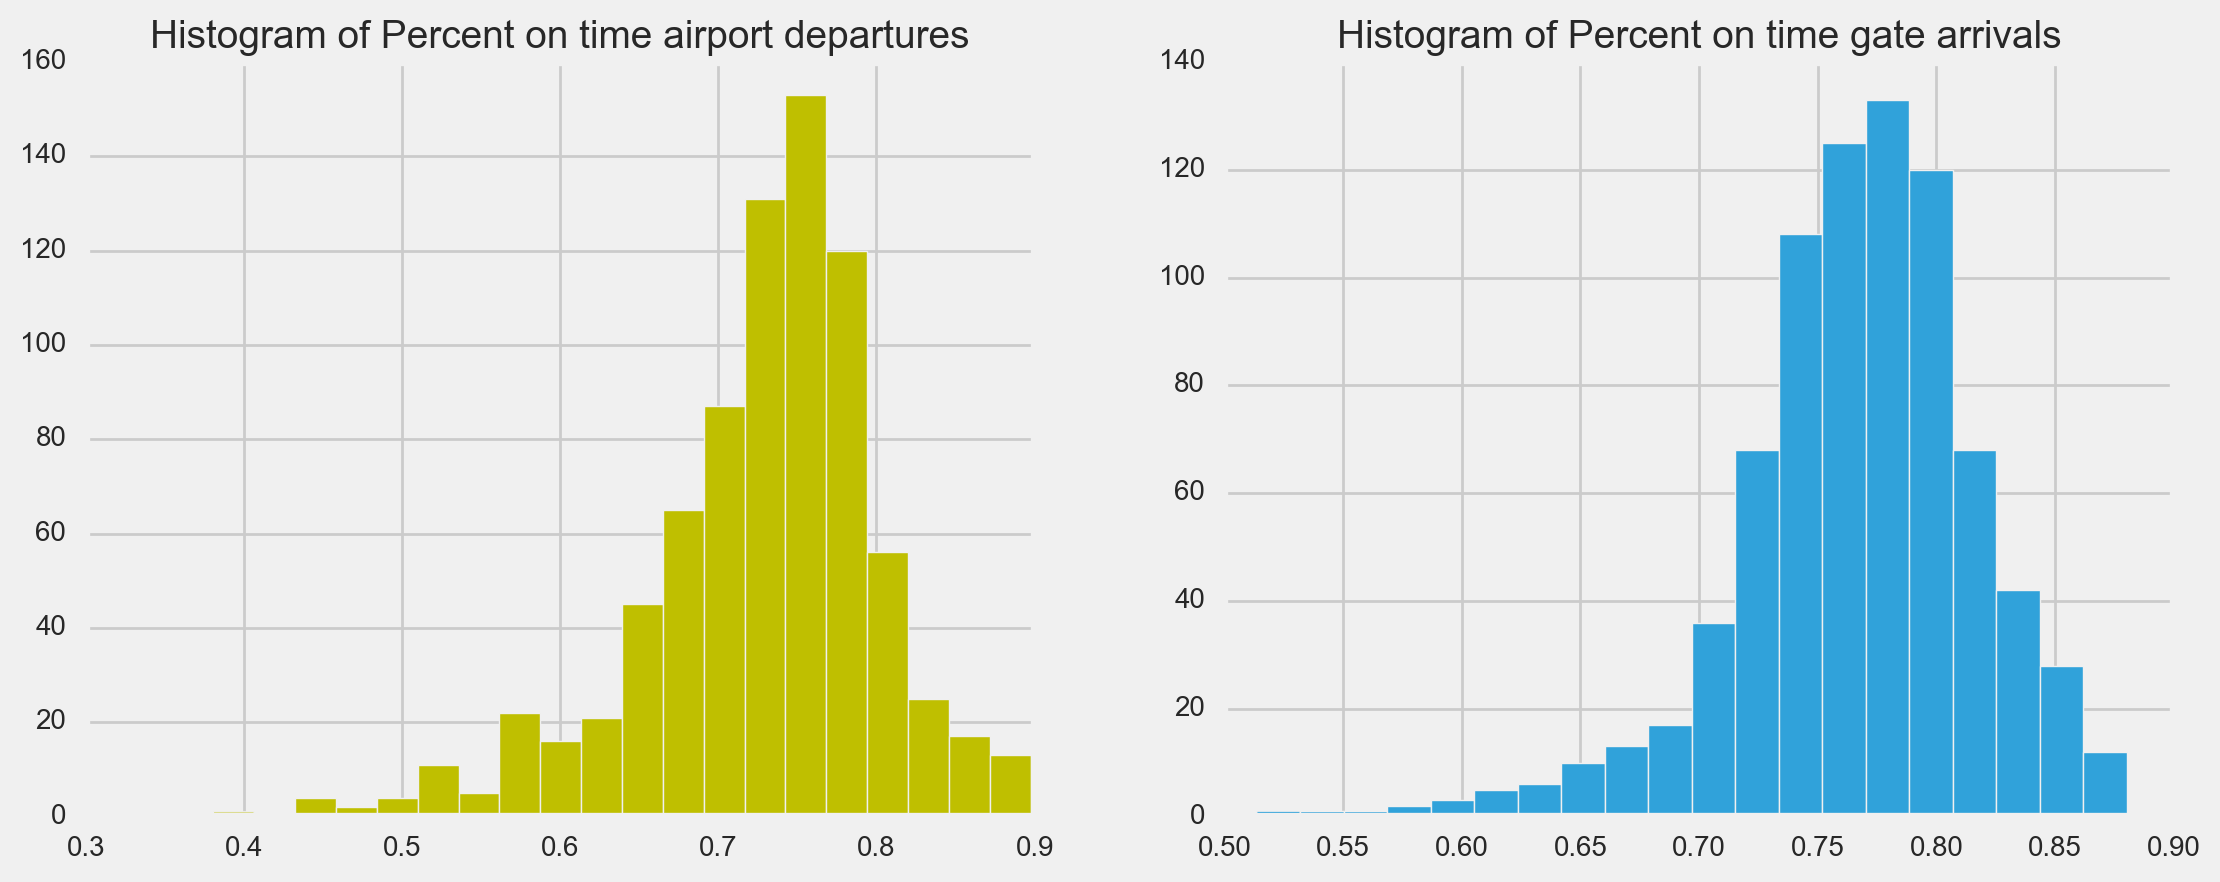

In [19]:
fig = plt.subplots(figsize=(12,10))

ax1 = plt.subplot(221)
plt.hist(full_ops_df.percent_on_time_airport_departures, bins=20, color='y')
plt.title('Histogram of Percent on time airport departures', fontsize = 14)

ax2 = plt.subplot(222)
plt.hist(full_ops_df.percent_on_time_gate_arrivals, bins=20)
plt.title('Histogram of Percent on time gate arrivals', fontsize = 14)

plt.show()

#### 4.2 Find correlations in the data

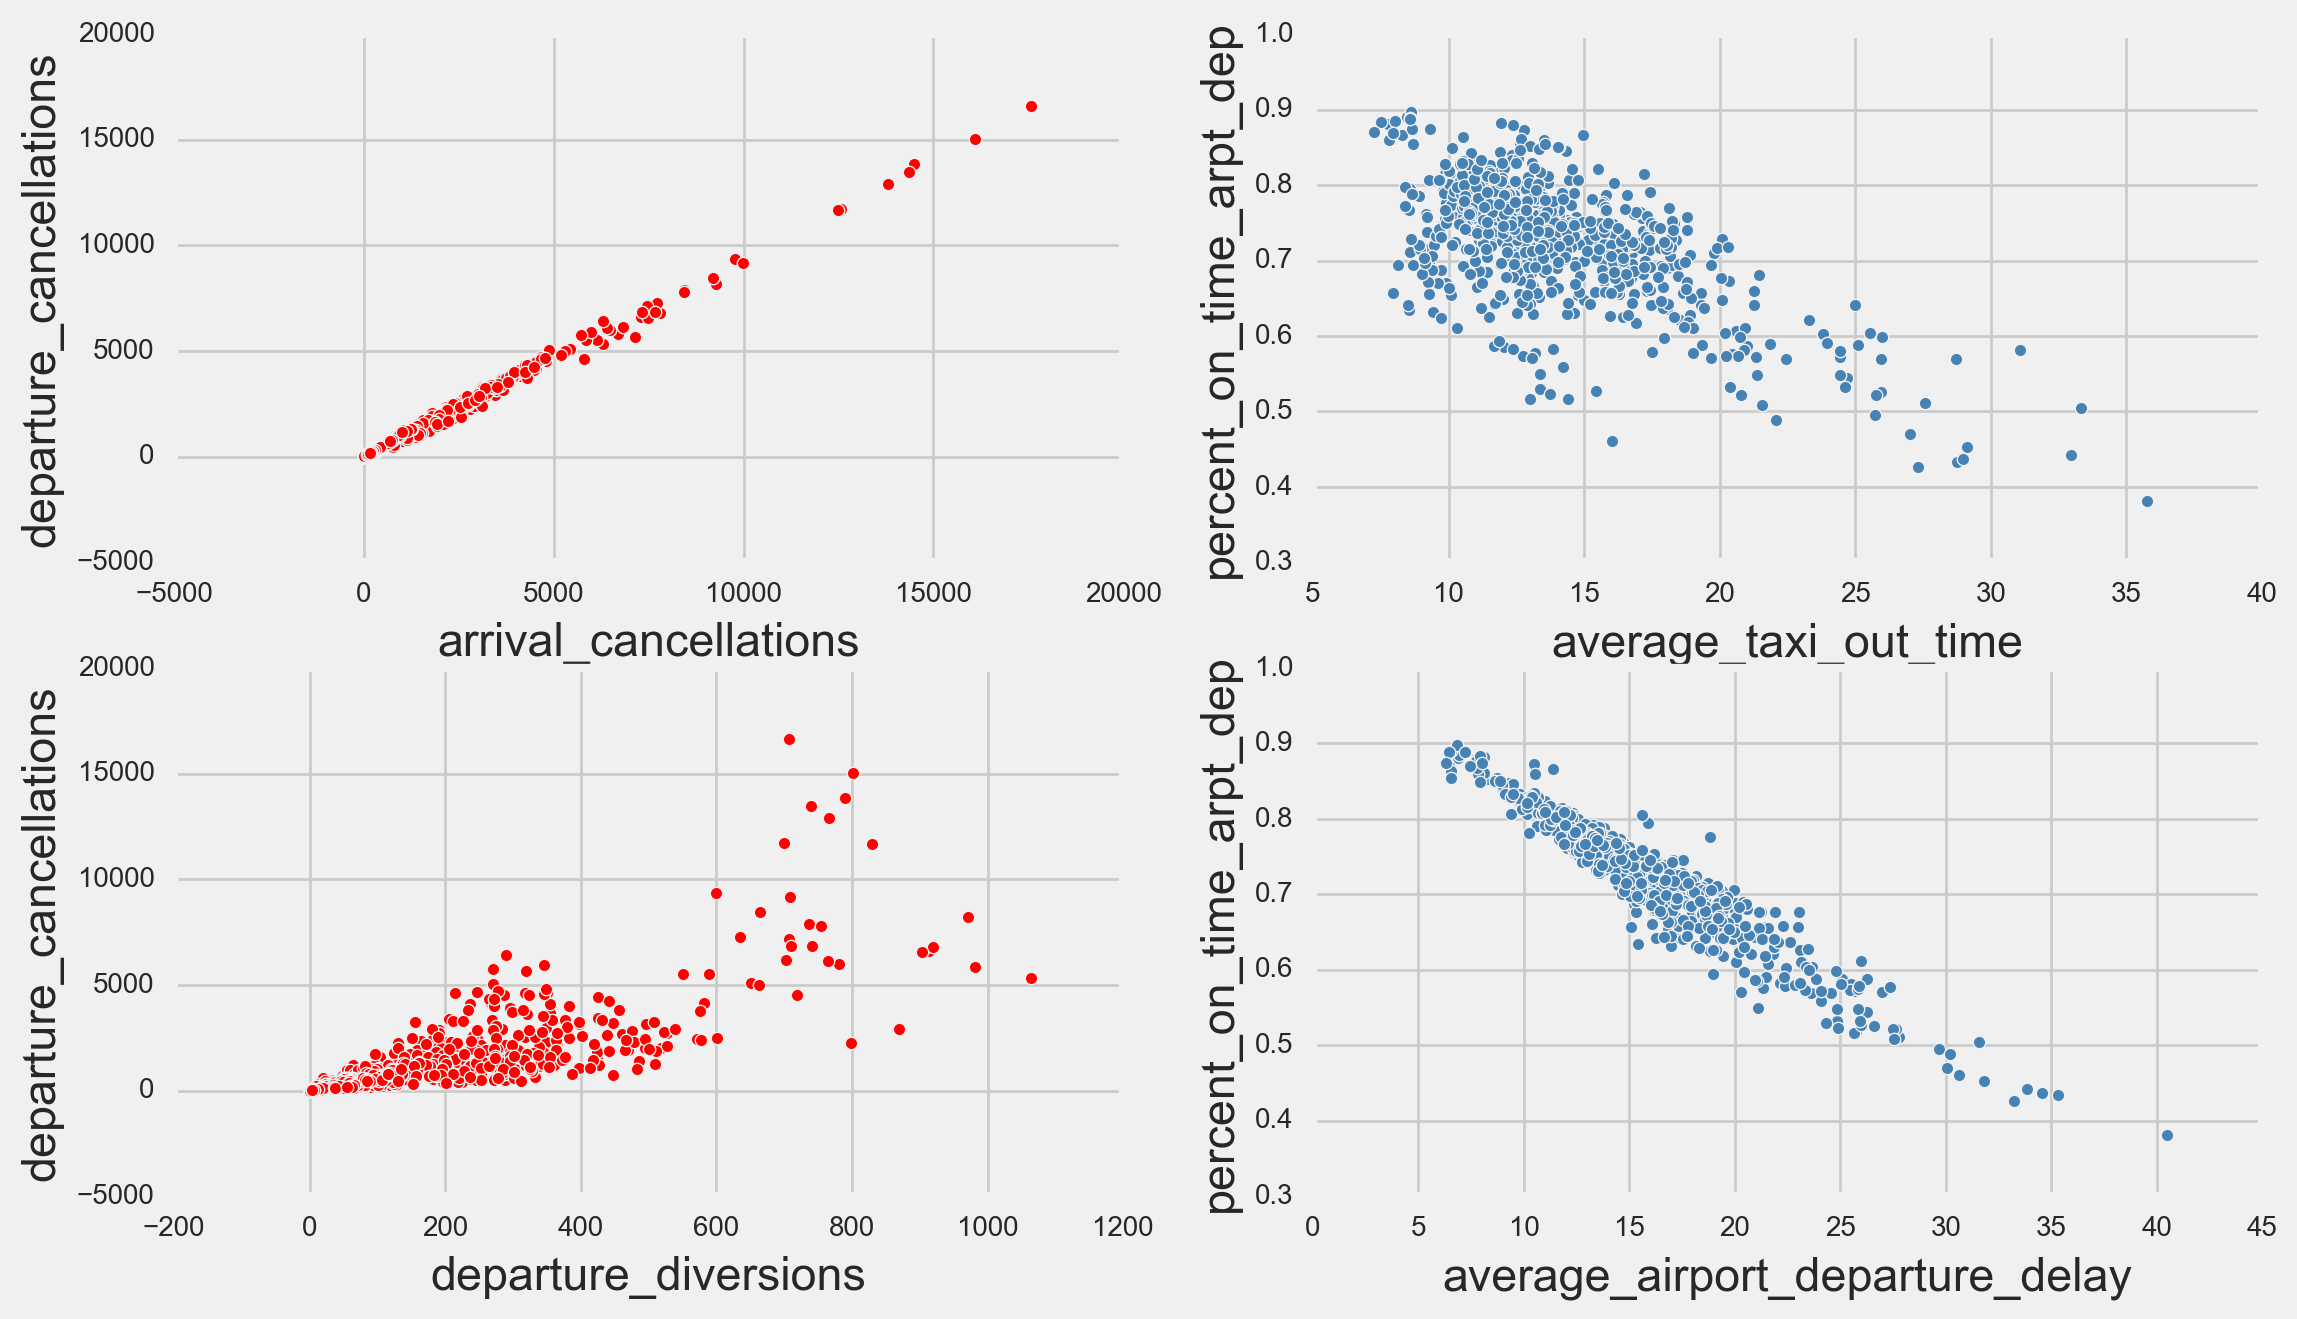

In [20]:
fig = plt.subplots(figsize=(12,7))

ax1 = plt.subplot(221)
full_ops_df.plot(kind='scatter',x="arrival_cancellations", 
                 y="departure_cancellations", ax=ax1, c='red')

ax2 = plt.subplot(223)
full_ops_df.plot(kind='scatter',x="departure_diversions", 
                 y="departure_cancellations", ax=ax2, c='red')

ax3 = plt.subplot(222)
full_ops_df.plot(kind='scatter', x="average_taxi_out_time", 
                 y="percent_on_time_airport_departures", ax=ax3, c='steelblue')
plt.ylabel('percent_on_time_arpt_dep')

ax4 = plt.subplot(224)
full_ops_df.plot(kind='scatter',x="average_airport_departure_delay", 
                 y="percent_on_time_airport_departures", ax=ax4, c='steelblue')
plt.ylabel('percent_on_time_arpt_dep')

plt.show()

#### 4.3 What is the value of understanding correlations before PCA? 

It shows that some features really have strong correlation, this indicates that would be possible to reduce the dimensionality of the data features.

### Part 5: Perform a PCA and Present Findings

#### Conduct the PCA

In [21]:
X.shape

(799, 17)

In [62]:
X

array([[-0.57471319, -0.55884073, -0.59844728, ..., -0.68388851,
        -0.7493269 , -0.7874207 ],
       [-0.58612795, -0.58157695, -0.6564081 , ..., -0.61364466,
        -0.96173661, -0.98129006],
       [-0.49317926, -0.51134727, -0.59844728, ..., -0.6721812 ,
        -0.63806466, -0.49507802],
       ..., 
       [-0.64265814, -0.62351266, -0.78971799, ..., -0.78925429,
        -1.01231036, -0.85819841],
       [-0.61113168, -0.60027119, -0.65061202, ..., -0.83608352,
        -0.82013014, -0.20581264],
       [-0.60950101, -0.59926069, -0.69118459, ..., -0.57852273,
        -0.7290974 ,  0.40964564]])

In [22]:
pca = PCA()
pca.fit_transform(X)
pca.explained_variance_
ratio = pca.explained_variance_ratio_

In [23]:
len(ratio)

17

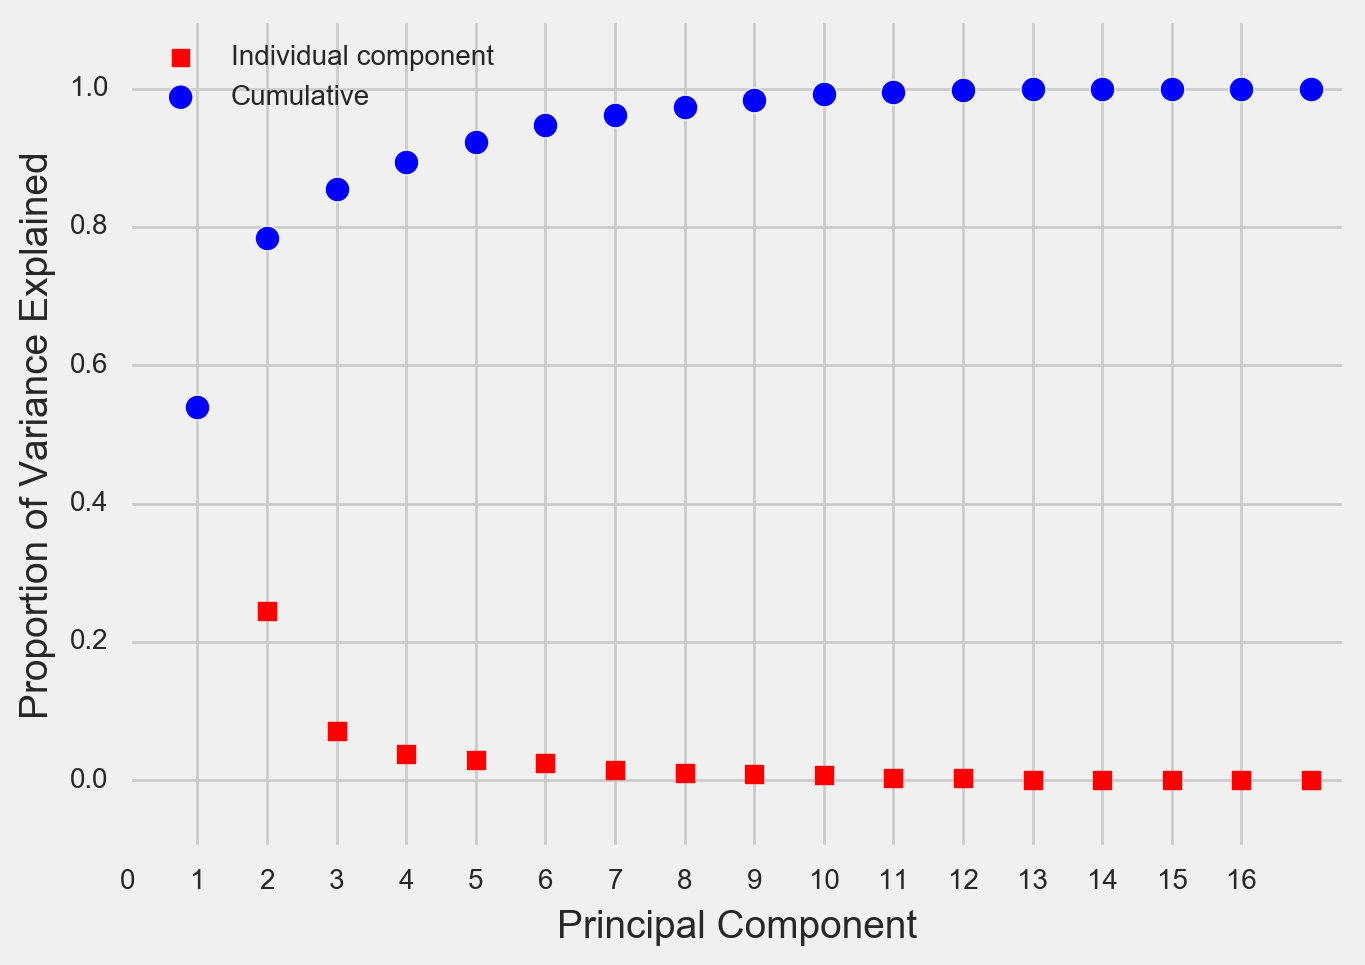

In [24]:
plt.figure(figsize=(7,5))

plt.scatter(range(1,len(ratio)+1), ratio, color='r', s=40, marker='s', label='Individual component')
plt.scatter(range(1,len(ratio)+1), np.cumsum(ratio), s=80, label='Cumulative')

plt.ylabel('Proportion of Variance Explained', fontsize=14)
plt.xlabel('Principal Component', fontsize=14)
plt.xlim(0.5,17.5)
plt.ylim(-0.1,1.1)
plt.xticks(range(len(ratio)))

plt.legend(loc=2);
plt.show()

#### We see that the first 3 PCs retain almost 90% variance, so let' move forward with 3 PCs

In [25]:
my_pca = PCA(n_components=3)
X_pca = my_pca.fit_transform(X)

In [26]:
#pca_loadings = pd.DataFrame(my_pca.fit(X).components_.T, index=features, columns=['PC1', 'PC2','PC3'])
#pca_loadings

In [27]:
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression

k_vals = range(2,6)

log_clf = LogisticRegression()

for k in k_vals:
    my_kmean = KMeans(n_clusters=k)
    my_kmean.fit(X_pca)
    labels = my_kmean.labels_
    print k, cross_val_score(log_clf, X_pca, labels, cv=10).mean(), silhouette_score(X_pca, labels)

2 0.996280864198 0.489576974811
3 0.952356032193 0.308415289073
4 0.924954995606 0.348791464756
5 0.924707037128 0.37331563792


#### We see that with k=2, the scores look good. Let's move forward with classifying airports into 2 groups

In [28]:
my_kmean = KMeans(n_clusters=2)
my_kmean.fit(X_pca)
pca_labels = my_kmean.labels_

In [29]:
full_ops_df.head()

airport    year  departure_cancellations  arrival_cancellations  \
0     ABQ  2004.0                    242.0                  235.0   
1     ABQ  2005.0                    221.0                  190.0   
2     ABQ  2006.0                    392.0                  329.0   
3     ABQ  2007.0                    366.0                  304.0   
4     ABQ  2008.0                    333.0                  300.0   

   departure_diversions  arrival_diversions airport  year  \
0                  71.0                46.0     ABQ  2004   
1                  61.0                33.0     ABQ  2005   
2                  71.0               124.0     ABQ  2006   
3                 107.0                45.0     ABQ  2007   
4                  79.0                42.0     ABQ  2008   

   departures_for_metric_computation  arrivals_for_metric_computation  \
0                              53971                            53818   
1                              51829                            51877   
2                              49682                            51199   
3                              53255                            53611   
4                              49589                            49512   

              ...              percent_on_time_airport_departures  \
0             ...                                          0.7809   
1             ...                                          0.7922   
2             ...                                          0.7756   
3             ...                                          0.7704   
4             ...                                          0.7844   

   percent_on_time_gate_arrivals  average_gate_departure_delay  \
0                         0.7921                         10.38   
1                         0.8001                          9.60   
2                         0.7746                         10.84   
3                         0.7647                         11.29   
4                         0.7875                         10.79   

   average_taxi_out_time  average_taxi_out_delay  \
0                   9.89                    2.43   
1                   9.79                    2.29   
2                   9.89                    2.16   
3                  10.34                    2.40   
4                  10.41                    2.41   

   average_airport_departure_delay  average_airborne_delay  \
0                            12.10                    2.46   
1                            11.20                    2.26   
2                            12.33                    2.12   
3                            12.95                    2.19   
4                            12.32                    1.82   

   average_taxi_in_delay  average_block_delay  average_gate_arrival_delay  
0                   0.83                 2.55                       10.87  
1                   0.89                 2.34                       10.24  
2                   0.84                 2.66                       11.82  
3                   1.29                 3.06                       12.71  
4                   1.03                 2.79                       11.48  

[5 rows x 21 columns]

In [30]:
colors = []
for i in range(len(labels)):
    if labels[i] ==0:
        colors.append('r')
    else:
        colors.append('b')

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied

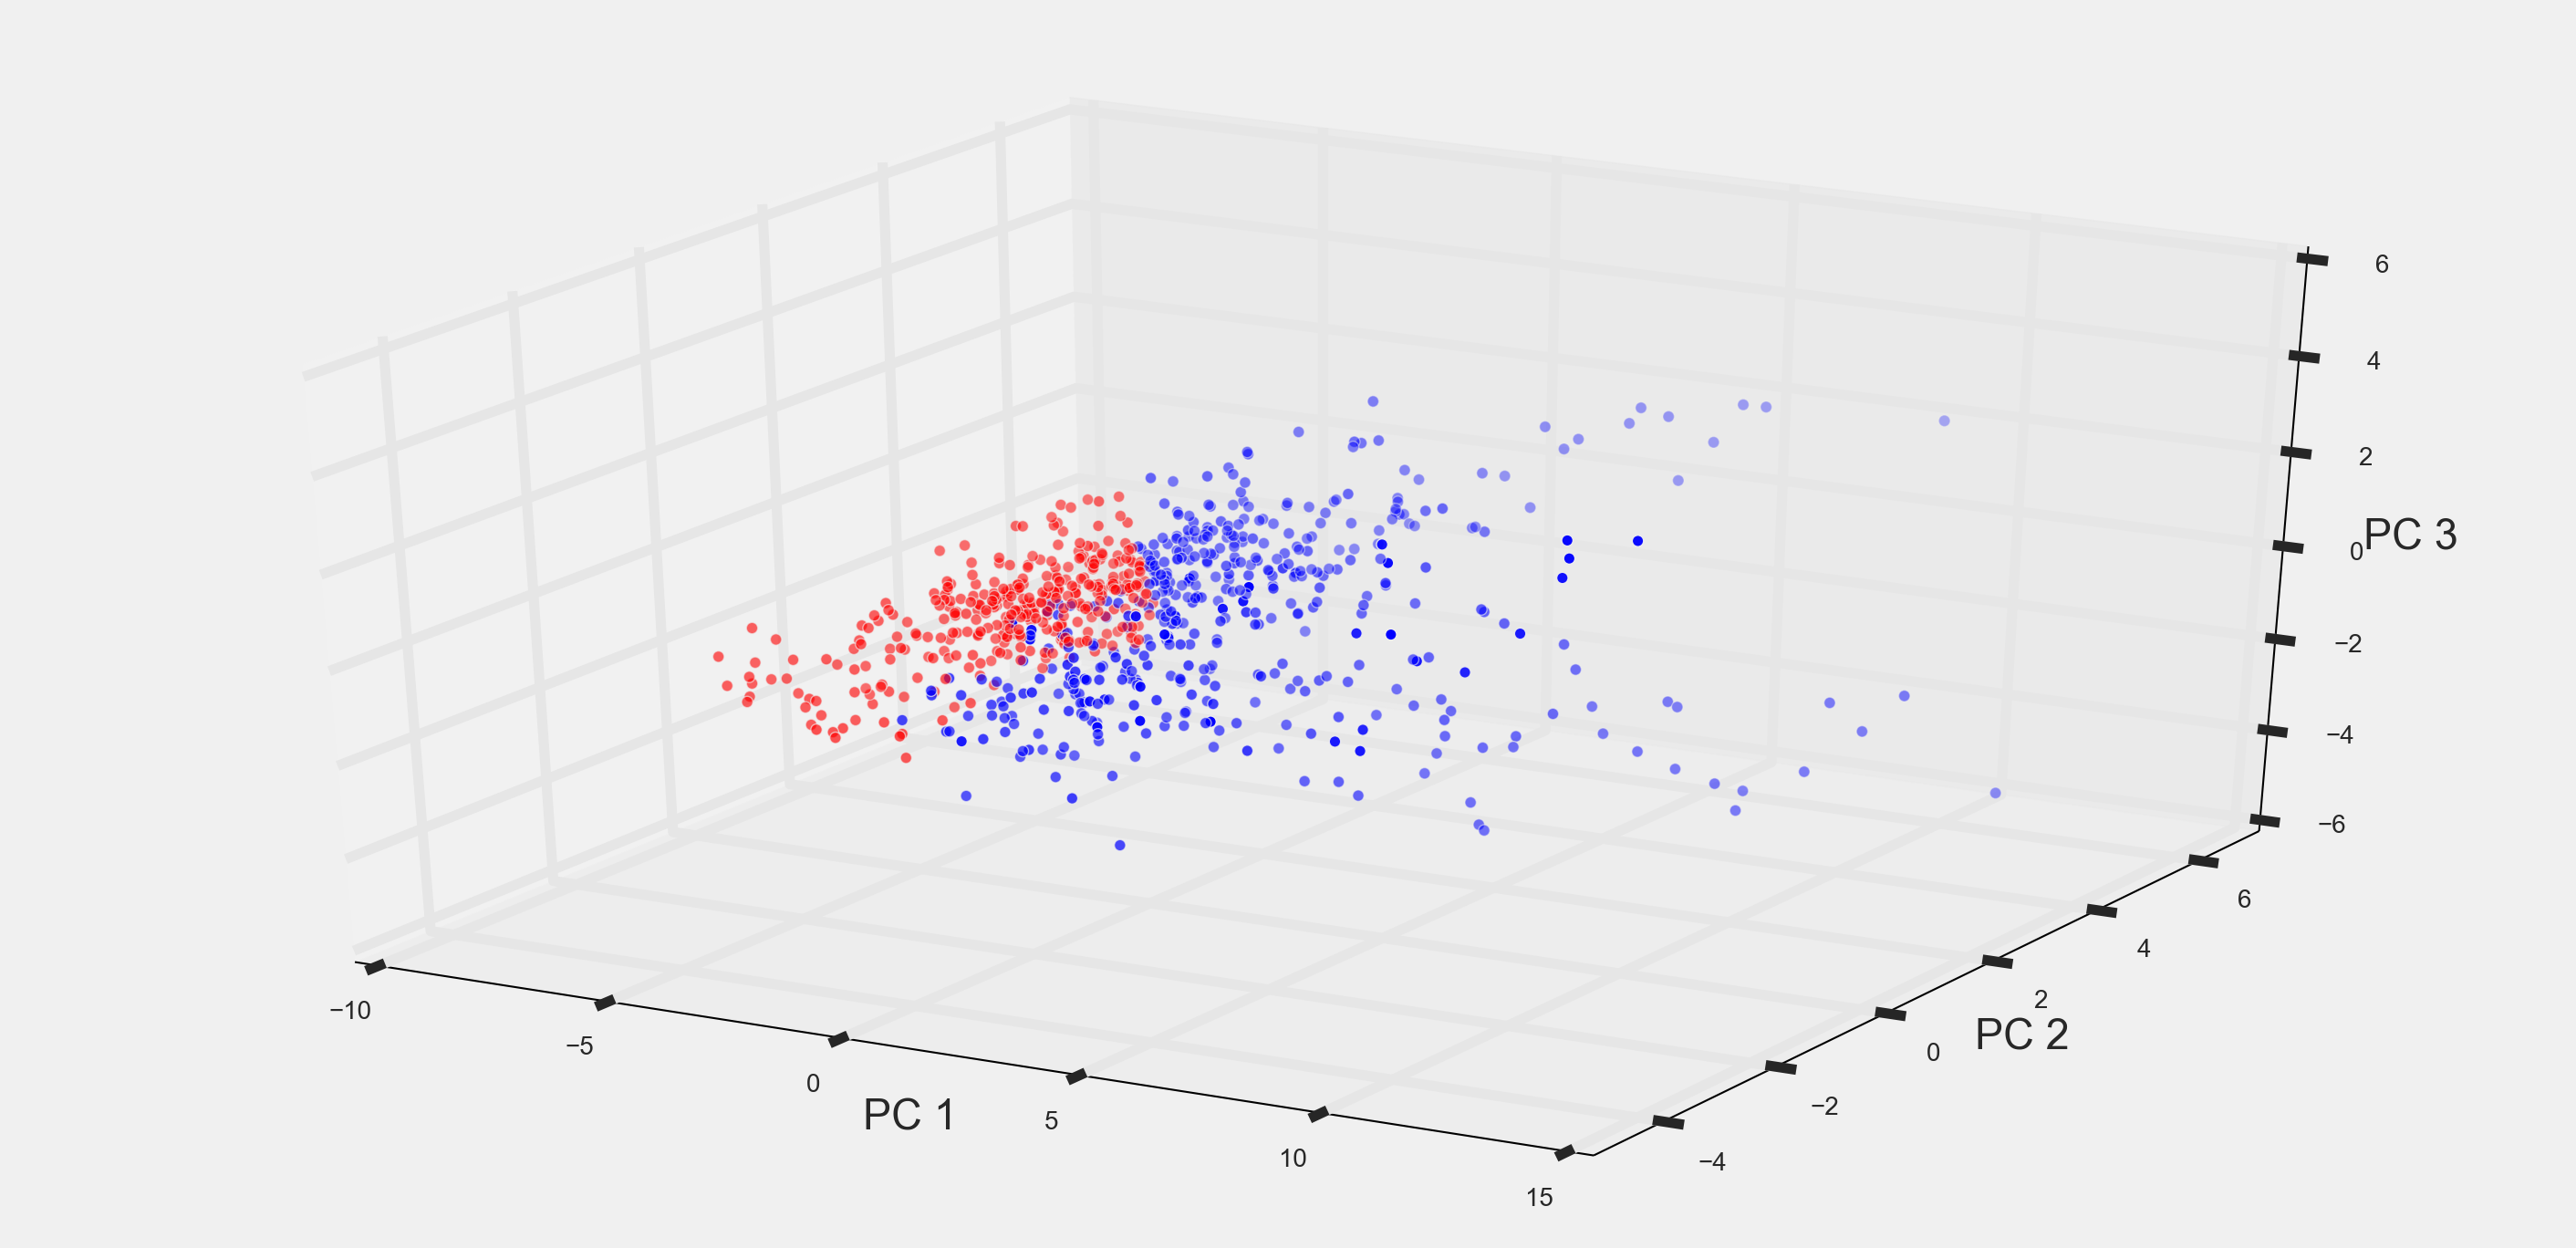

In [31]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(16,8)).gca(projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], depthshade=True, c=colors)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.axis('equal')
plt.show()

In [32]:
length = len(full_ops_df)
arpt_titles = [ str(full_ops_df.ix[i,0]) + ' ' + str(full_ops_df.ix[i,7]) for i in range(length)]

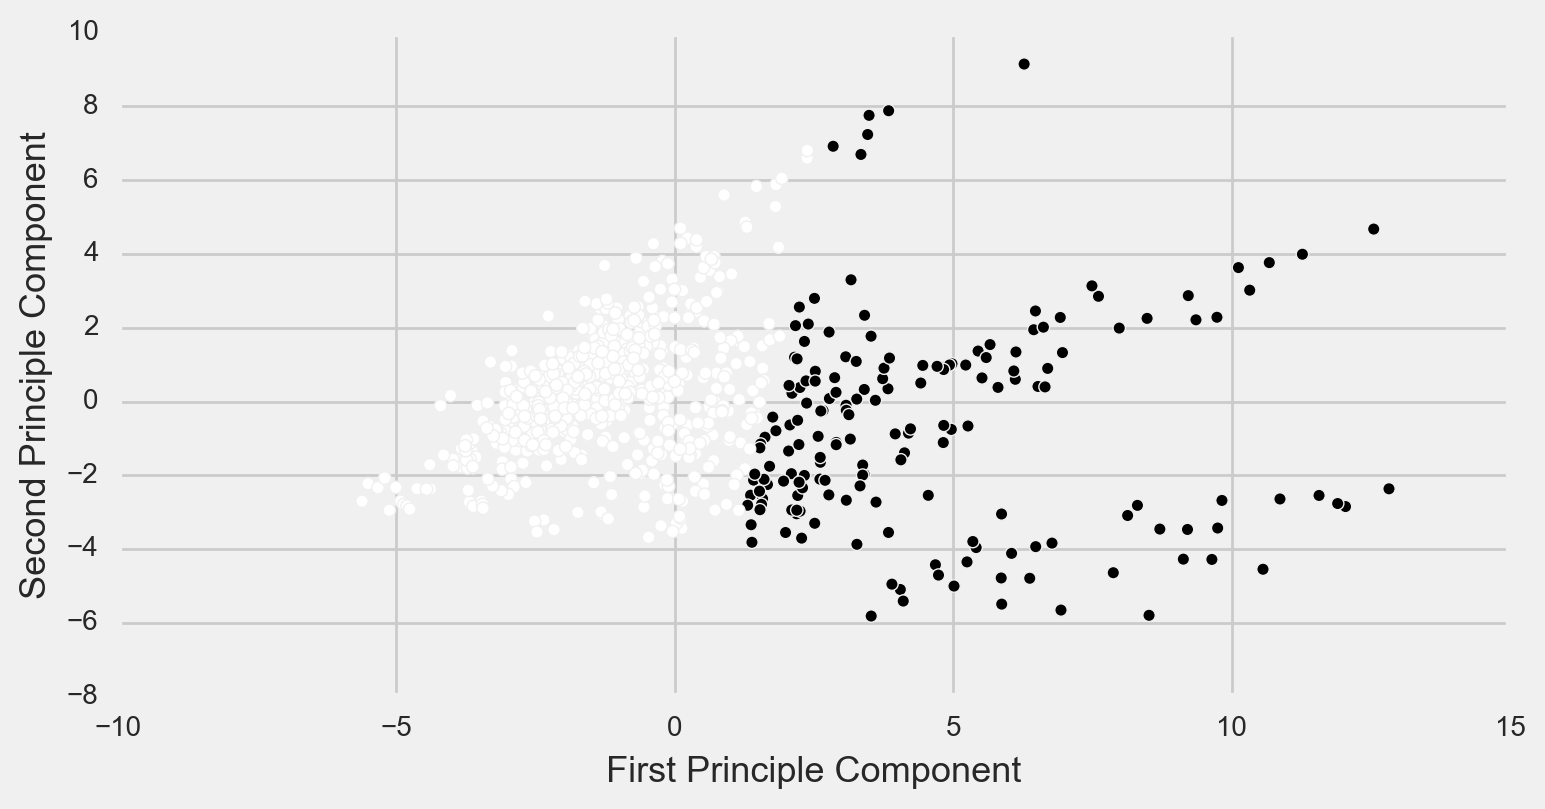

In [33]:
plt.figure(figsize=(8,4))
plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=pd.DataFrame(pca_labels).values, alpha=1)
plt.xlabel('First Principle Component', fontsize=13)
plt.ylabel('Second Principle Component', fontsize=13)
plt.show()

In [34]:
# A more interactive plot to see what airport belong to each group

import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('PythonAPI', 'ubpiol2cve')

data = [
    go.Scatter(
        x=X_pca[:,0],
        y=X_pca[:,1],
        mode='markers',
        marker = dict(size = 6, color = labels),
        text=arpt_titles
    )
]

layout = go.Layout(
    title='Airport pca-kmeans'
)

fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='Airport pca-kmeans')

ImportError: No module named plotly.plotly

#### view plot [here](https://plot.ly/~PythonAPI/2746/airport-pca-kmeans/)

### Part 6: Perform a tSNE and clustering using k-means and Present Findings

In [35]:
from sklearn.manifold import TSNE
my_tsne = TSNE(n_components=2)

In [36]:
X_tsne = my_tsne.fit_transform(X)

In [37]:
my_kmean = KMeans(n_clusters=2)
my_kmean.fit(X_tsne)
tsne_labels = my_kmean.labels_

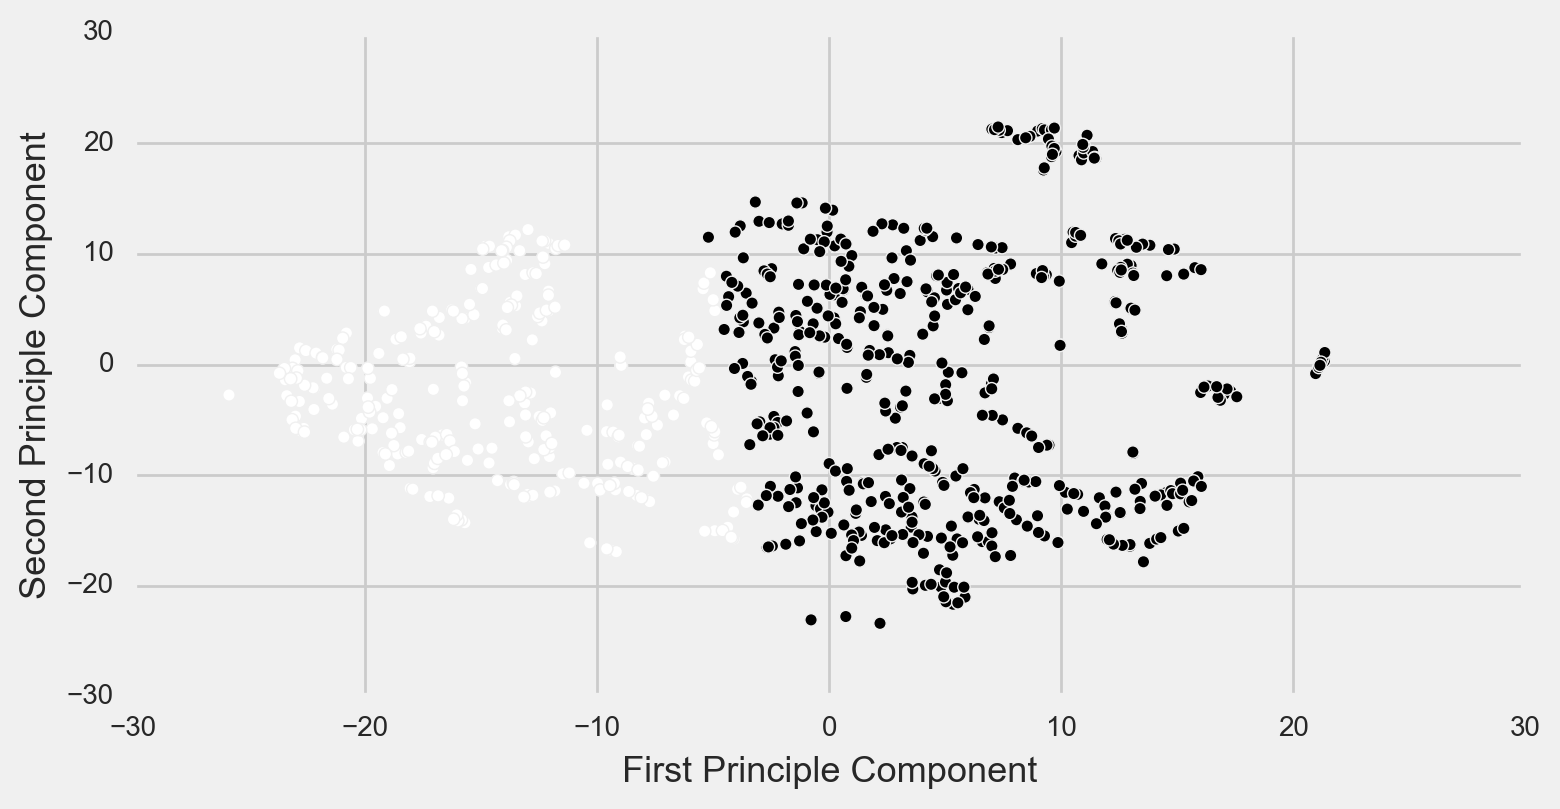

In [38]:
plt.figure(figsize=(8,4))
plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1], c=pd.DataFrame(tsne_labels).values, alpha=1)
plt.xlabel('First Principle Component', fontsize=13)
plt.ylabel('Second Principle Component', fontsize=13)
plt.show()

In [42]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Scatter(
        x=X_tsne[:,0],
        y=X_tsne[:,1],
        mode='markers',
        marker = dict(size = 6, color = labels),
        text=arpt_titles
    )
]

layout = go.Layout(
    title='Airport tSNE-kmeans'
)

fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='Airport tSNE-kmeans')

Aw, snap! We don't have an account for ''. Want to try again? You can authenticate with your email address or username. Sign in is not case sensitive.

Don't have an account? plot.ly

Questions? support@plot.ly


#### view plot [here](https://plot.ly/~PythonAPI/2748/airport-tsne-kmeans/)

### Part 7: Analysis of Principle Components for two airport groups

+ The k-means clustering (with 2 groups) indicates that it would be possible to perform the classification, based on reduced dimentions, using either PCA or tSNE
+ Since the purpose of this work is to determine which variables make a more significant contribution to the airports' operation, I'm not diving into comparing tSNE and PCA. Instead, I will move further with principle component analysis on two groups of clusters to analyze the feature importance.


In [43]:
my_pca = PCA(n_components=3)
X_pca = my_pca.fit_transform(X)

my_kmean = KMeans(n_clusters=2)
my_kmean.fit(X_pca)
labels = my_kmean.labels_

In [44]:
group0_df = full_ops_df[labels==0]
group1_df = full_ops_df[labels==1]

In [45]:
group0_df.describe()

year  departure_cancellations  arrival_cancellations  \
count   174.000000               174.000000             174.000000   
mean   2008.563218              3658.080460            3888.287356   
std       3.120698              2752.871374            2958.560937   
min    2004.000000               290.000000             258.000000   
25%    2006.000000              1963.750000            2150.250000   
50%    2008.000000              2854.500000            3016.000000   
75%    2011.000000              4479.750000            4591.250000   
max    2014.000000             16618.000000           17571.000000   

       departure_diversions  arrival_diversions         year  \
count            174.000000          174.000000   174.000000   
mean             400.310345          464.563218  2008.563218   
std              212.541016          331.900943     3.120698   
min               14.000000           41.000000  2004.000000   
25%              248.250000          214.000000  2006.000000   
50%              344.500000          357.500000  2008.000000   
75%              509.500000          638.750000  2011.000000   
max             1064.000000         1948.000000  2014.000000   

       departures_for_metric_computation  arrivals_for_metric_computation  \
count                         174.000000                       174.000000   
mean                       249935.367816                    248884.224138   
std                        100123.681863                    100146.527484   
min                         30230.000000                     30777.000000   
25%                        189769.000000                    188664.000000   
50%                        226751.500000                    225950.000000   
75%                        301032.250000                    300023.000000   
max                        491826.000000                    486799.000000   

       percent_on_time_gate_departures  percent_on_time_airport_departures  \
count                       174.000000                          174.000000   
mean                          0.754202                            0.643393   
std                           0.051717                            0.080996   
min                           0.529900                            0.380800   
25%                           0.729450                            0.588575   
50%                           0.760550                            0.659150   
75%                           0.789850                            0.705550   
max                           0.860700                            0.766300   

       percent_on_time_gate_arrivals  average_gate_departure_delay  \
count                     174.000000                    174.000000   
mean                        0.746318                     14.856609   
std                         0.058805                      3.228350   
min                         0.513600                      8.390000   
25%                         0.719400                     12.425000   
50%                         0.752100                     14.215000   
75%                         0.790650                     16.837500   
max                         0.842200                     25.840000   

       average_taxi_out_time  average_taxi_out_delay  \
count             174.000000              174.000000   
mean               18.884195                6.737356   
std                 4.228104                3.114851   
min                12.370000                3.030000   
25%                15.962500                4.457500   
50%                17.910000                5.595000   
75%                20.432500                8.235000   
max                35.760000               18.940000   

       average_airport_departure_delay  average_airborne_delay  \
count                       174.000000              174.000000   
mean                         20.533333                3.988276   
std                           5.018741                1.360233   
min      

In [46]:
group0_df.describe() - group1_df.describe() 

year  departure_cancellations  arrival_cancellations  \
count -451.000000              -451.000000            -451.000000   
mean    -0.579182              3015.446860            3256.364156   
std     -0.028459              2253.474984            2432.971271   
min      0.000000               290.000000             258.000000   
25%      0.000000              1676.750000            1890.250000   
50%     -1.000000              2366.500000            2559.000000   
75%     -1.000000              3601.750000            3731.250000   
max      0.000000             13365.000000           14439.000000   

       departure_diversions  arrival_diversions        year  \
count           -451.000000         -451.000000 -451.000000   
mean             288.995145          376.241618   -0.579182   
std              126.671623          256.125757   -0.028459   
min               14.000000           41.000000    0.000000   
25%              194.250000          179.000000    0.000000   
50%              257.500000          297.500000   -1.000000   
75%              358.500000          510.750000   -1.000000   
max              581.000000         1411.000000    0.000000   

       departures_for_metric_computation  arrivals_for_metric_computation  \
count                        -451.000000                      -451.000000   
mean                       174455.321416                    173709.329738   
std                         46466.203595                     46799.317941   
min                         29499.000000                     30060.000000   
25%                        152661.000000                    151760.000000   
50%                        165565.500000                    164701.000000   
75%                        199574.250000                    198918.000000   
max                        211880.000000                    211221.000000   

       percent_on_time_gate_departures  percent_on_time_airport_departures  \
count                      -451.000000                         -451.000000   
mean                         -0.031859                           -0.106830   
std                           0.001396                            0.025465   
min                          -0.047200                           -0.149200   
25%                          -0.031550                           -0.131125   
50%                          -0.031150                           -0.093650   
75%                          -0.026750                           -0.077550   
max                          -0.049000                           -0.131100   

       percent_on_time_gate_arrivals  average_gate_departure_delay  \
count                    -451.000000                   -451.000000   
mean                       -0.026265                      2.513793   
std                         0.012411                      0.485478   
min                        -0.075500                      3.040000   
25%                        -0.028800                      1.875000   
50%                        -0.021600                      1.985000   
75%                        -0.011550                      2.837500   
max                        -0.038100                      4.200000   

       average_taxi_out_time  average_taxi_out_delay  \
count            -451.000000             -451.000000   
mean                6.406467                3.904316   
std                 2.079045                2.129165   
min                 5.130000                2.930000   
25%                 4.892500                2.277500   
50%                 5.520000                2.955000   
75%                 6.912500                4.845000   
max                16.960000               11.910000   

       average_airport_departure_delay  average_airborne_delay  \
count                      -451.000000             -451.000000   
mean                          6.174453                1.422532   
std                           2.008984                0.468338   
min                       

+ ##### The above descriptions of two groups indicates that they have similar operational natures (e.g. percent on time flights, etc), but are different in the absolute values of flight cancels and delays. So it was suggested that this k-means clustring probably grouped the airports into small and big ones.

+ ##### Now I will do PCA on each group of airports that was separated by k-means

In [47]:
X_g0 = StandardScaler().fit_transform(group0_df[features])
X_g1 = StandardScaler().fit_transform(group1_df[features])

In [48]:
my_pca = PCA(n_components=2)
pca_loadings_g0 = pd.DataFrame(my_pca.fit(X_g0).components_.T, index=features, 
                               columns=['PC1_good_aprt', 'PC2'])
good_arpt = pca_loadings_g0.PC1_good_aprt.abs().sort_values(ascending=True)

In [49]:
pca_loadings_g1 = pd.DataFrame(my_pca.fit(X_g1).components_.T, index=features, 
                               columns=['PC1_bad_aprt', 'PC2'])
bad_arpt = pca_loadings_g1.PC1_bad_aprt.abs().sort_values(ascending=True)

In [53]:
pca_loadings_g1

PC1_bad_aprt       PC2
departure_cancellations                 0.331337 -0.022102
arrival_cancellations                   0.342052 -0.034243
departure_diversions                    0.334019 -0.078364
arrival_diversions                      0.300714 -0.032881
departures_for_metric_computation       0.350485 -0.097093
arrivals_for_metric_computation         0.350439 -0.098270
percent_on_time_gate_departures        -0.019910 -0.392745
percent_on_time_airport_departures     -0.119732 -0.377253
percent_on_time_gate_arrivals           0.056773 -0.392936
average_gate_departure_delay            0.026879  0.407711
average_taxi_out_time                   0.283513  0.030432
average_taxi_out_delay                  0.307500  0.041550
average_airport_departure_delay         0.115725  0.395482
average_airborne_delay                  0.182353  0.090233
average_taxi_in_delay                   0.282403 -0.023652
average_block_delay                     0.071496  0.185504
average_gate_arrival_delay             -0.021199  0.390725

In [50]:
def remove_underscore(aa):
    return aa.replace('_',' ')

In [51]:
compare = pd.merge(pd.DataFrame(good_arpt).reset_index(), 
          pd.DataFrame(bad_arpt).reset_index())

In [54]:
compare

index  PC1_good_aprt  PC1_bad_aprt
0              departure_cancellations       0.044092      0.331337
1                arrival_cancellations       0.060960      0.342052
2                average_taxi_in_delay       0.070294      0.282403
3                   arrival_diversions       0.101084      0.300714
4                 departure_diversions       0.213511      0.334019
5      arrivals_for_metric_computation       0.219924      0.350439
6    departures_for_metric_computation       0.219939      0.350485
7                average_taxi_out_time       0.222522      0.283513
8               average_airborne_delay       0.231934      0.182353
9               average_taxi_out_delay       0.235597      0.307500
10                 average_block_delay       0.251812      0.071496
11     percent_on_time_gate_departures       0.272067      0.019910
12        average_gate_departure_delay       0.300723      0.026879
13          average_gate_arrival_delay       0.331644      0.021199
14  percent_on_time_airport_departures       0.334499      0.119732
15     average_airport_departure_delay       0.335309      0.115725
16       percent_on_time_gate_arrivals       0.340389      0.056773

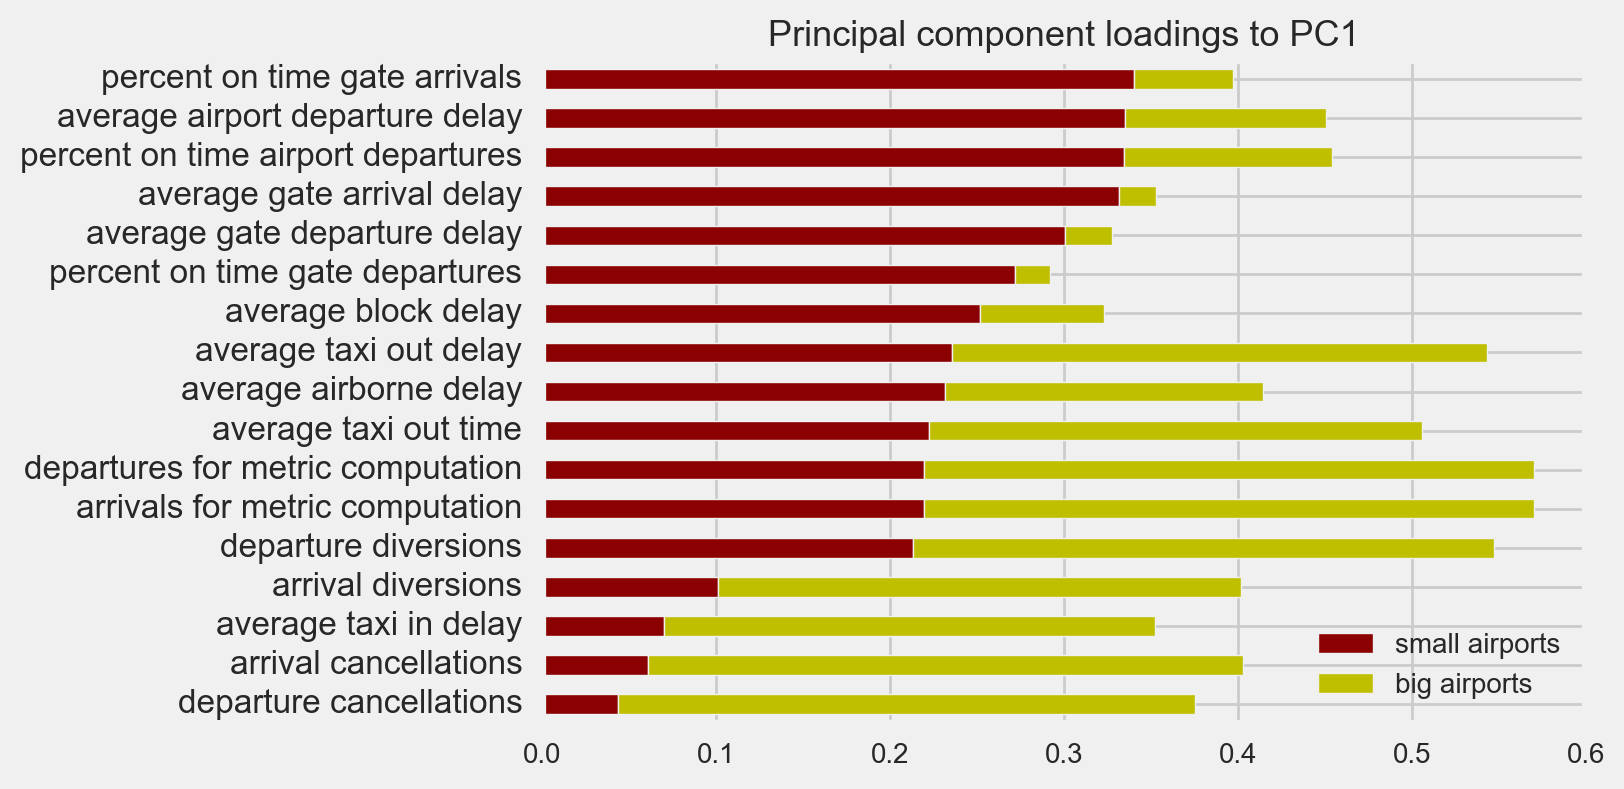

In [63]:
ax = compare.plot(kind = 'barh', color =['darkred','y'], stacked=True)
ax.set_yticklabels( compare['index'].apply(remove_underscore), fontsize = 12, rotation=0)
plt.legend(['small airports','big airports'], loc='best') # vorsicht: good and bad airports not nec small and big
# plt.legend(['good airports','bad airports'], loc='best') # vorsicht: good and bad airports not nec small and big

plt.title('Principal component loadings to PC1', fontsize=13)
plt.show()

### Comments:
+ From the analysis above, we see that two airport groups have significant difference in the contributions of features to PCs
+ For the group of good airports with less flight cancelations and delays, main contribution to the first PC come from departures for metric computation, arrivals for metric computation, arrival cancellations, departure diversions, departure cancellations and average taxi out delay. 
+ Whereas for the other group of airports, main contribution to the first PC comes from percent on time gate departures, average gate arrival delay, average gate departure delay, percent on time gate arrivals, etc.

In [1]:
!pwd

/Users/jam3/local/MY_KEY_WORK/DSI_KEY_DOCS/DTLA_2/PROJECTS/HIEU_PHAM/Data-master/project_7
